In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import glob
import pandas as pd
import os
import cartopy.crs as ccrs


def spatial_mean(da):
    """Computes the spatial mean if lat and lon dimensions are present."""
    if 'lat' in da.dims and 'lon' in da.dims:
        return da.mean(dim=['lat', 'lon'])
    return da

# Convert cftime.DatetimeNoLeap to numpy.datetime64
def convert_time(ds):
    ds['time'] = [pd.Timestamp(time.strftime()) for time in ds['time'].values]
    return ds


# Data Retrieval
    ## Select either Monethly (h0) daily (h1) or Hourly(h2) using wild card

In [2]:
# Directory where the netCDF files are located
data_directory = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/sim_results/monthly'  # Current directory. Adjust this if your files are elsewhere.

# File pattern
# h0 is 20 years of 24 monthly files, each file contains just one monthly output  
file_pattern = "i.e215.I2000Clm50SpGs.hw_production.02.clm2.h0.*.nc"

file_path_pattern = os.path.join(data_directory, file_pattern)

## Get the list of files using the pattern

In [3]:
file_list = glob.glob(file_path_pattern)
file_list.sort(key=lambda x: os.path.basename(x).split('.')[-2])


In [4]:
# os.listdir(directory)
len(file_list)

360

## Open the files using Dask and Xarray

In [5]:
# List of variables to drop
drop_vars = ["ZSOI", "DZSOI", "WATSAT", "SUCSAT", "BSW", "HKSAT", "ZLAKE", "DZLAKE"]


In [6]:
# ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4', chunks={'time': 480})
ds = xr.open_mfdataset(file_list, combine='by_coords', engine='netcdf4', drop_variables=drop_vars)

## Convert the cftime.DatetimeNoLeap objects to pandas Timestamps

In [7]:
#ds = convert_time(ds)

## examine the xarray object

In [9]:
ds

<xarray.Dataset>
Dimensions:        (levgrnd: 25, levlak: 10, levdcmp: 1, time: 360,
                    hist_interval: 2, lon: 288, lat: 192)
Coordinates:
  * levgrnd        (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak         (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp        (levdcmp) float32 1.0
  * time           (time) object 1985-02-01 00:00:00 ... 2015-01-01 00:00:00
  * lon            (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat            (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Dimensions without coordinates: hist_interval
Data variables: (12/68)
    mcdate         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mcsec          (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdcur          (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    mscur          (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nstep          (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    time_bounds    (time, hist_interval) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...             ...
    VAPOR_PRES_U   (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WASTEHEAT      (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA            (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA_R          (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WBA_U          (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    WIND           (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
Attributes: (12/38)
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/13/24 20:20:28
    source:                                    Community Land Model CLM4.0
    hostname:                                  JohnnyThinkStation
    ...                                        ...
    ctype_urban_shadewall:                     73
    ctype_urban_impervious_road:               74
    ctype_urban_pervious_road:                 75
    cft_c3_crop:                               1
    cft_c3_irrigated:                          2
    time_period_freq:                          month_1

# Convert K to C for TBOT

In [10]:
ds['TBOT_C'] = ds['TBOT'] - 273.15

# Update the attributes for the new variable to reflect the change in units
ds['TBOT_C'].attrs['units'] = 'C'
ds['TBOT_C'].attrs['long_name'] = '2m air temperature in Celsius'

# Weighting and Averaging


## Area Weighted


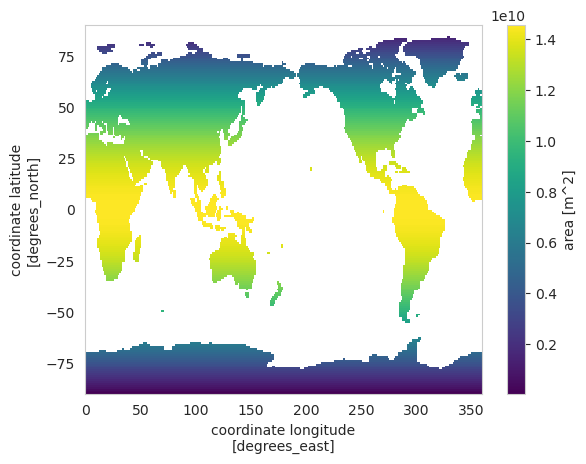

In [11]:
#pure land portion weight
#la = (ds.landfrac*ds.area).isel(time=0).drop(['time'])
#just area weight
la = (ds.area).isel(time=0).drop(['time'])
# the unit should not matter in the context of calculating weight
la = la * 1e6  #converts from land area from km2 to m2 
la.attrs['units'] = 'm^2'
lw = la
lw.plot() 

In [12]:
lw.sum().values

array(1.6694878e+14, dtype=float32)

In [13]:
def compute_weighted_avg_vectorized(ds, lw):
    # Normalize the area weights to sum to 1
    lw_normalized = lw / lw.sum(dim=['lat', 'lon'])

    # Filter the dataset to include only data variables with 'lat' and 'lon' dimensions
    data_vars_with_latlon = {name: var for name, var in ds.data_vars.items() if {'lat', 'lon'}.issubset(var.dims)}

    # Use the filtered data variables to create a new dataset
    ds_with_latlon = xr.Dataset(data_vars_with_latlon)

    # Perform the vectorized operation of multiplying each variable by the area weights
    weighted_ds = ds_with_latlon * lw_normalized

    # Sum over the 'lat' and 'lon' dimensions to get the weighted average
    weighted_avg_ds = weighted_ds.sum(dim=['lat', 'lon'])

    return weighted_avg_ds

# Call the function with the dataset and land weights
weighted_avg_dataset = compute_weighted_avg_vectorized(ds, lw)

# weighted_avg_dataset now contains the weighted averages for each variable


## yearly avg, the resample command is important and cool

In [14]:

yearly_avg = weighted_avg_dataset.resample(time='AS-FEB').mean()

In [15]:
yearly_avg
#print(yearly_avg.time[0])

<xarray.Dataset>
Dimensions:        (time: 30)
Coordinates:
  * time           (time) object 1985-02-01 00:00:00 ... 2014-02-01 00:00:00
Data variables: (12/61)
    area           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landfrac       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landmask       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pftmask        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nbedrock       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    APPAR_TEMP     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...             ...
    WASTEHEAT      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA_R          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA_U          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WIND           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    TBOT_C         (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

# Define Variables to Report

In [16]:
variables = ['TBOT_C', 'QBOT', 'RAIN', 'EFLX_LH_TOT', 'FSH']

In [17]:
# Calculate spatial average for each variable
for var in variables:
    yearly_avg[var] = spatial_mean(yearly_avg[var])


# Convert time axis to integer year

In [18]:
yearly_avg = yearly_avg.assign_coords(time=yearly_avg.time.dt.year)

In [19]:
print(yearly_avg)

<xarray.Dataset>
Dimensions:        (time: 30)
Coordinates:
  * time           (time) int64 1985 1986 1987 1988 1989 ... 2011 2012 2013 2014
Data variables: (12/61)
    area           (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landfrac       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    landmask       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    pftmask        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nbedrock       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    APPAR_TEMP     (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...             ...
    WASTEHEAT      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA            (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA_R          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WBA_U          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    WIND           (time) float

# Plot time series of yearly average

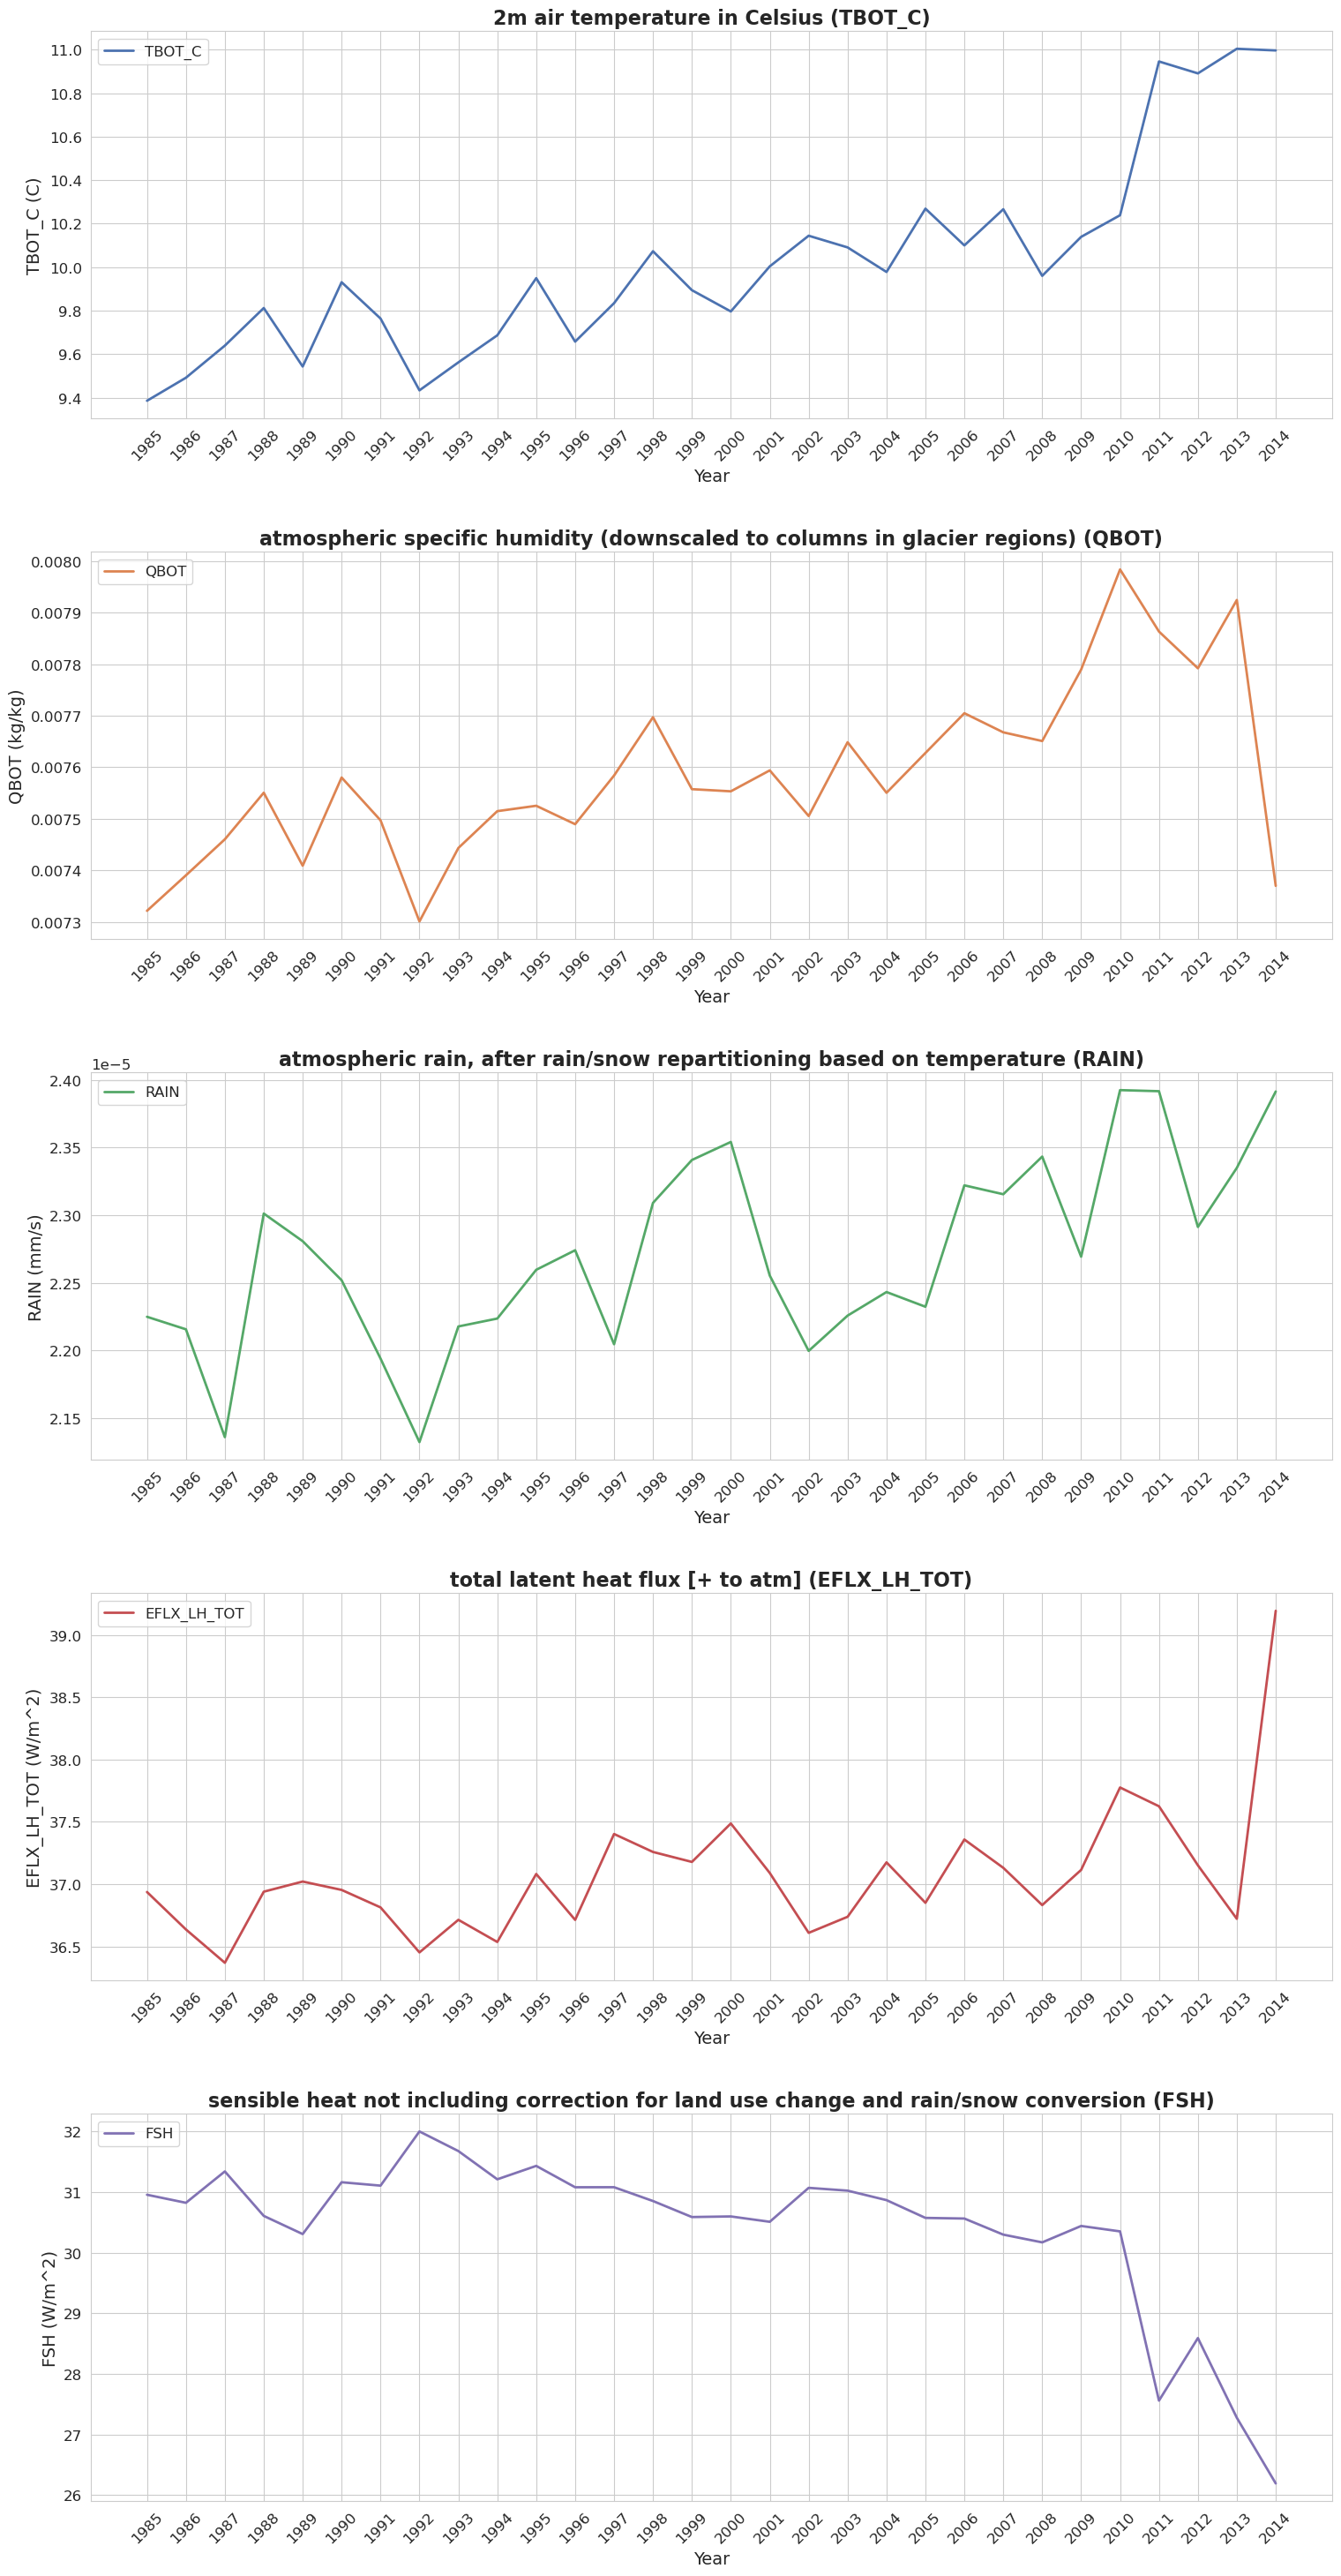

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")  # Use seaborn's whitegrid style
plt.rcParams['font.size'] = 12  # Increase default font size

# Assuming 'yearly_avg' is your data and 'variables' is a list of variable names you want to plot
# Create subplots for each variable
fig, axes = plt.subplots(nrows=len(variables), ncols=1, figsize=(16, 6 * len(variables)))

# Ensure 'axes' is an array even with a single subplot
if len(variables) == 1:
    axes = [axes]

colors = sns.color_palette("deep", len(variables))  # A palette of distinct colors for each variable

for ax, var, color in zip(axes, variables, colors):
    ax.plot(yearly_avg['time'], yearly_avg[var], label=var, color=color, linewidth=2)

    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel(f'{var} ({ds[var].attrs.get("units", "unknown units")})', fontsize=14)  # Retrieving units from dataset attributes

    # Fetching long_name from attributes and forming the title
    long_name = ds[var].attrs.get('long_name', var)  # Using var as default if long_name is absent
    ax.set_title(f'{long_name} ({var})', fontsize=16, fontweight='bold')

    ax.legend(loc='upper left')

    # Set x-axis ticks to show each year
    ax.set_xticks(yearly_avg['time'])  # Set ticks at each year in the 'time' array
    ax.set_xticklabels(yearly_avg['time'].values, rotation=45)  # Set tick labels to show the year, rotating for readability

plt.tight_layout(pad=3)  # Adjust padding
plt.show()
